# CNN

In [1]:
import tensorflow.keras as keras

In [2]:
# Módulos necesarios. Asegurarse de poder importarlos.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pylab import rcParams
from scipy import stats
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
import os as os
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from time import time

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
tf.__version__

/usr/bin/python
3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


'1.14.0'

In [4]:
keras.__version__

'2.2.4-tf'

# 10-FOLD

In [5]:
subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
global activities
activities = [9,10,11,12,13,19,20,21,24,25,31]

In [6]:
# Ajustado a los datos
n_time_steps = 128
n_classes = 11 # Nº de clases (el 0 está eliminado)
n_channels = 1 # Nº de canales
n_columns = 20

# Podríamos variarlo
batch_size = 128 # Tamaño del batch
learning_rate = 1e-3 # Learning rate (por defecto es 0.001)
epochs = 100 # Épocas

In [7]:
class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
        # compute the set of learning rates for each correRPonding
        # epoch
        lrs = [self(i) for i in epochs]
 
        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
class StepDecay(LearningRateDecay):
    def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
        # store the base initial learning rate, drop factor, and
        # epochs to drop every
        self.initAlpha = initAlpha
        self.factor = factor
        self.dropEvery = dropEvery
 
    def __call__(self, epoch):
        # compute the learning rate for the current epoch
        exp = np.floor((1 + epoch) / self.dropEvery)
        alpha = self.initAlpha * (self.factor ** exp)
        if(alpha<1e-9):
            alpha=1e-9

        # return the learning rate
        return float(alpha) 

schedule = StepDecay(initAlpha=learning_rate, factor=0.4, dropEvery=10)

reduce_lr = keras.callbacks.LearningRateScheduler(schedule, verbose = 1)
callbacks_list = [reduce_lr]

In [8]:
#Visualize training evolution
def plot_curves(model, acc, loss, val_acc, val_loss, kfold):
    #########################################################################################
    # LOSS plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[loss], label='Training loss')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Loss in trainnig', fontsize=20)
    fig = plt.gcf()
    plt.show()
    
    fig.savefig('./02AUG_RP_KFOLD_models/loss_train_02AUG_RP_KFOLD_'+kfold+'.pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./02AUG_RP_KFOLD_models/loss_train_02AUG_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[acc], label='Training accuracy')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Accuracy in training', fontsize=20)
    fig = plt.gcf()
    plt.show()

    fig.savefig('./02AUG_RP_KFOLD_models/acc_train_02AUG_RP_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./02AUG_RP_KFOLD_models/acc_train_02AUG_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC+LOSS plot
    plt.figure(figsize=(14,10))
    plt_loss = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    plt_acc = plt_loss.twinx()
    plt_acc.axis["right"].toggle(all=True)
    
    plt_loss.set_xlim(0, len(model.history.history[loss]))
    plt_loss.set_ylim(0, max(model.history.history[loss]))
    plt_loss.set_xlabel('Epochs')
    plt_loss.set_ylabel('Loss')
    plt_acc.set_ylabel('Accuracy')
                        
    plt_loss.axis['left'].label.set_fontsize(15)
    plt_loss.axis['bottom'].label.set_fontsize(15)
    plt_acc.axis['right'].label.set_fontsize(15)
    
    plt_loss.plot(model.history.history[loss], c='tab:blue', ls='--', label='Training loss')
    plt_acc.plot(model.history.history[acc], c='tab:orange',ls='--', label='Training accuracy')
    
    plt.tick_params(labelsize=10)
    plt.title('Training performance', fontsize=20)
    plt_acc.set_ylim(0, 1)
    plt_loss.legend(loc=1, prop={'size': 10})
    
    fig = plt.gcf()
    plt.show()

    fig.savefig('./02AUG_RP_KFOLD_models/all_train_02AUG_RP_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./02AUG_RP_KFOLD_models/all_train_02AUG_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')

In [9]:
def plot_confusion_matrix(y_true, y_pred, kfold, classes,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, square = True, robust = True, annot=True, cmap='YlOrBr')
    plt.title('CONFUSION MATRIX')
    plt.ylabel('TRUE ACTIVITY')
    plt.xlabel('PREDICTION')
    
    locs, labels = plt.xticks()
    plt.xticks(locs, labels, rotation='vertical')
    locs, labels = plt.yticks()
    plt.yticks(locs, labels, rotation='horizontal')

    # Guardamos la imagen en formato vectorial
    plt.draw()
    plt.savefig('./02AUG_RP_KFOLD_models/matriz_confusion_'+kfold+'.svg', bbox_inches='tight',format='svg')
    plt.show()

In [10]:
global size
size = 26125

In [11]:
from sklearn.model_selection import KFold
S = np.arange(0,size)
kf = KFold(n_splits=10)
kf.get_n_splits(S)

print(kf)  

S_train = []
S_test = []

for train_index, test_index in kf.split(S):
    print("TRAIN:", train_index, "TEST:", test_index)
    print(S[train_index])
    print(S[test_index])
    S_train.append(S[train_index])
    S_test.append(S[test_index])

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 2613  2614  2615 ... 26122 26123 26124] TEST: [   0    1    2 ... 2610 2611 2612]
[ 2613  2614  2615 ... 26122 26123 26124]
[   0    1    2 ... 2610 2611 2612]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [2613 2614 2615 ... 5223 5224 5225]
[    0     1     2 ... 26122 26123 26124]
[2613 2614 2615 ... 5223 5224 5225]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [5226 5227 5228 ... 7836 7837 7838]
[    0     1     2 ... 26122 26123 26124]
[5226 5227 5228 ... 7836 7837 7838]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [ 7839  7840  7841 ... 10449 10450 10451]
[    0     1     2 ... 26122 26123 26124]
[ 7839  7840  7841 ... 10449 10450 10451]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [10452 10453 10454 ... 13062 13063 13064]
[    0     1     2 ... 26122 26123 26124]
[10452 10453 10454 ... 13062 13063 13064]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [13065 13066 13067 ... 

##################################################################################################################################
#####################################################  K-FOLD 1  ################################################################
Train dataset: 
(23512, 1, 128, 20) (23512, 11)
Test dataset: 
(2613, 1, 128, 20) (2613, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


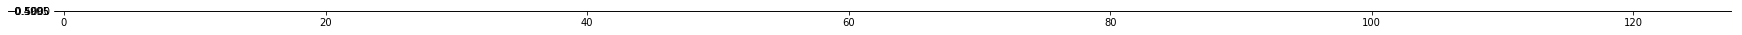

Activity:  19


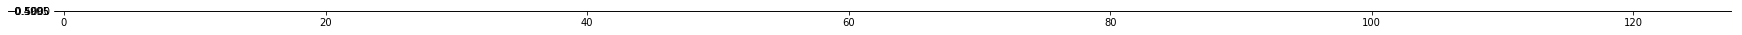

Activity:  13
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 20)       544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 10)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 64, 10)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 10)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 16, 3)         0       

In [ ]:
accuracies = []
for i in range(10):
    if(i<10):
        kfold='0'+str(i)
    else:
        kfold=str(i)
    print('##################################################################################################################################')
    print('#####################################################  K-FOLD %d  ################################################################'%(i+1))
    
    subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
    
    ##  GENERACIÓN DATASET
    tr_seg = np.concatenate((np.load('./augment/subject_'+subjects[0]+'_seg.npy'),np.load('./augment/subject_'+subjects[1]+'_seg.npy'),np.load('./augment/subject_'+subjects[2]+'_seg.npy'),np.load('./augment/subject_'+subjects[3]+'_seg.npy'),
                             np.load('./augment/subject_'+subjects[4]+'_seg.npy'),np.load('./augment/subject_'+subjects[5]+'_seg.npy'),np.load('./augment/subject_'+subjects[6]+'_seg.npy'),np.load('./augment/subject_'+subjects[7]+'_seg.npy'),
                             np.load('./augment/subject_'+subjects[8]+'_seg.npy'),np.load('./augment/subject_'+subjects[9]+'_seg.npy'),np.load('./augment/subject_'+subjects[10]+'_seg.npy')))

    tr_lab = np.concatenate((np.load('./augment/subject_'+subjects[0]+'_lab.npy'),np.load('./augment/subject_'+subjects[1]+'_lab.npy'),np.load('./augment/subject_'+subjects[2]+'_lab.npy'),np.load('./augment/subject_'+subjects[3]+'_lab.npy'),
                             np.load('./augment/subject_'+subjects[4]+'_lab.npy'),np.load('./augment/subject_'+subjects[5]+'_lab.npy'),np.load('./augment/subject_'+subjects[6]+'_lab.npy'),np.load('./augment/subject_'+subjects[7]+'_lab.npy'),
                             np.load('./augment/subject_'+subjects[8]+'_lab.npy'),np.load('./augment/subject_'+subjects[9]+'_lab.npy'),np.load('./augment/subject_'+subjects[10]+'_lab.npy')))
    
    limit = 20
    tr_seg = tr_seg[:,:,:,:limit]
    ####################################################################################################################
    ## SHUFFLE DE DATOS
    np.random.seed(235)
    tr_seg = np.reshape(tr_seg[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (size,1,128,limit))
    tr_lab = np.reshape(tr_lab[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (size,11))
    
    ts_seg = tr_seg[S_test[i]]
    ts_lab = tr_lab[S_test[i]]
    
    tr_seg = tr_seg[S_train[i]]
    tr_lab = tr_lab[S_train[i]]
    
    print('Train dataset: ')
    print(tr_seg.shape, tr_lab.shape)
    print('Test dataset: ')
    print(ts_seg.shape, ts_lab.shape)
    ####################################################################################################################
    ## VISTA DE DFT-2D
    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.abs(np.fft.fftshift(tr_seg[0,0,:,20:40].T))**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[0])])

    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.fft.fftshift(tr_seg[10,0,:,20:40].T)**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[10])])
    ####################################################################################################################
    ## RED
    quat_input = keras.Input(shape=(n_channels, n_time_steps, n_columns), name='input_layer')
    
    # Some convolutional layers
    conv_1 = keras.layers.Conv2D(32, kernel_size=4,padding='same',activation='relu', data_format = 'channels_first')(quat_input)
    max_1 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_1)
    bn_1 = keras.layers.BatchNormalization(axis=1)(max_1)
    conv_2 = keras.layers.Conv2D(64,kernel_size=4, padding='same',activation='relu', data_format = 'channels_first')(bn_1)
    max_2 = keras.layers.MaxPooling2D(pool_size=4, strides=4, padding='same', data_format = 'channels_first')(conv_2)
    bn_2 = keras.layers.BatchNormalization(axis=1)(max_2)
    conv_3 = keras.layers.Conv2D(32,kernel_size=4, padding='same',activation='relu', data_format = 'channels_first')(bn_2)
    max_3 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_3)
    bn_3 = keras.layers.BatchNormalization(axis=1)(max_3)

    # Flatten the output of the convolutional layers
    dr_2 = keras.layers.Dropout(0.5)(bn_3)

    units = 64

    res_1 = keras.layers.Reshape((8,units))(dr_2)

    gru_1 = keras.layers.GRU(units, activation='tanh', return_sequences=False, reset_after = False)(res_1)

    # Output layers: separate outputs for the weather and the ground labels
    multiclass_output = keras.layers.Dense(n_classes, activation='softmax',name='activity_class')(gru_1)

    # Creamos la estrcutura que contendrá a nuestro modelo
    model = keras.Model(inputs=quat_input, outputs=[multiclass_output],name='cnn')

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    print(model.summary())
    ####################################################################################################################
    ## TRAIN
    history = model.fit(tr_seg,
                        tr_lab,
                        epochs = epochs,
                        steps_per_epoch = None,
                        verbose = 1,
                        batch_size = batch_size,
                        callbacks = callbacks_list)
    model.save('./02AUG_RP_KFOLD_models/CNN_RNN_'+kfold+'.h5')
    
    #Visualize training evolution
    plot_curves(model, 'categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', kfold)
    ####################################################################################################################
    ## TEST
    predictions = model.predict(ts_seg, batch_size = batch_size, verbose = 1)
    
    print(predictions.shape)
    
    y_pred = np.argmax(predictions,axis=-1)
    y_pred = np.expand_dims(y_pred,axis=-1)
    print(y_pred[:100].T)
    
    y_true = np.argmax(ts_lab,axis=-1)
    y_true = np.expand_dims(y_true,axis=-1)
    print(y_true.shape)
    print(y_true[:100].T)
    
    evaluation = model.evaluate(ts_seg, ts_lab, batch_size=batch_size, verbose=1)
    accuracies.append(evaluation[1])
    
    fo = open('./02AUG_RP_KFOLD_models/accuracy_'+kfold+'.txt', "w")
    fo.seek(0,2)
    fo.write(str(evaluation))
    fo.close()
    
    ####################################################################################################################
    ## CONFUSION MATRIX
    y_true_flat = np.ndarray.flatten(y_true)
    y_pred_flat = np.ndarray.flatten(y_pred)
    
    plot_confusion_matrix(y_true_flat, y_pred_flat, kfold, classes=activities)
    
    del kfold, subjects, limit, tr_seg, tr_lab, ts_seg, ts_lab, model, history, y_pred, y_true, predictions, evaluation, y_true_flat, y_pred_flat
    

# Accuracy

In [16]:
sum = 0
for acc in accuracies:
    sum += acc
print('Accuracy of K-Fold: ' + str(sum/10))

Accuracy of K-Fold: 0.9625675797462463
